# Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import os
import cv2

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Dense, Dropout

# Test and Train Data

In [2]:
# Reading in DataFrames for Test and Train Data
test_df = pd.read_csv('data/test_labels.csv')
train_df = pd.read_csv('data/train_labels.csv')

# Dropping Unessecary Columns
test_df = test_df.drop(columns=['source'])
train_df = train_df.drop(columns=['source'])

# Finding all Images with 2+ Kangaroos

In [3]:
# Train Images
train_counts = train_df['filename'].value_counts()
train_counts = train_counts.loc[lambda x: x > 1]
train_removed = train_counts.index.to_list()

# Test Images
test_counts = test_df['filename'].value_counts()
test_counts = test_counts.loc[lambda x: x > 1]
test_removed = test_counts.index.to_list()

# Removing Rows from Test and Train DataFrame

In [4]:
# Removing rows that do not have an image that pertains to them
train_df_removed = train_df[~train_df.filename.isin(train_removed)]
test_df_removed = test_df[~test_df.filename.isin(test_removed)]

# Obtaining Train and Test Data

In [5]:
# Required Information
TRAINING_IMAGE_DIR = 'data\\images'
target = 216
target_size = (216, 216)

# Image Directory
train_image_path = os.path.join(os.getcwd(), TRAINING_IMAGE_DIR)

# Needed Lists for the images
train_images = []
train_targets = []
train_labels = []
missing_train_images = []

# Classes
classes = ['no kangaroo', 'kangaroo']

In [6]:
# Iterating through the Data Frame
for index, row in train_df_removed.iterrows():
    
    # Converging Rows into Specific Data
    (filename, width, height, class_name, xmin, ymin, xmax, ymax)  = row

    try:
        # Finding Image Path 
        train_image_fullpath = os.path.join(train_image_path, filename)

        # Resizing Images to Target Size
        train_img = keras.preprocessing.image.load_img(train_image_fullpath, target_size=target_size)

        # Turning Images to Array
        train_img_arr = keras.preprocessing.image.img_to_array(train_img)

        # Adds Training Images
        train_images.append(train_img_arr)

        # Adds Training Targets also Normalizing for Region-Based CNN
        train_targets.append(((xmin / width) * (target / width), # Top Left X
                             (ymin / height) * (target / height), # Top Left Y
                             (xmax / width) * (target / width),  # Bottom Right X
                             (ymax / height) * (target / height))) # Bottom Right X
        
        # Adding Labels for Training Classification 
        train_labels.append(classes.index(class_name))

    except FileNotFoundError:
        # Catches the filenames that do not have an image within the image file
        missing_train_images.append(filename)

    

In [7]:
# Required Information
TEST_IMAGE_DIR = 'data\\images'

# Image Directory
test_image_path = os.path.join(os.getcwd(), TEST_IMAGE_DIR)

# Test
test_images = []
test_targets = []
test_labels = []
missing_test_images = []
found_test_images = []

# test_widths = []
# test_heights = []

In [8]:
# Iterating through the Data Frame
for index, row in test_df_removed.iterrows():
    
    # Converging Rows into Specific Data
    (filename, width, height, class_name, xmin, ymin, xmax, ymax)  = row

    try:
        # Finding Image Path 
        test_image_fullpath = os.path.join(test_image_path, filename)

        # Resizing Images to Target Size
        test_img = keras.preprocessing.image.load_img(test_image_fullpath, target_size=target_size)

        # Turning Images to Array
        test_img_arr = keras.preprocessing.image.img_to_array(test_img)

        # Adds Training Images
        test_images.append(test_img_arr)

        # Adds Training Targets also Normalizing for Region-Based CNN
        test_targets.append(((xmin / width) * (target / width),  # Top Left X
                             (ymin / height) * (target / height), # Top Left Y
                             (xmax / width) * (target / width),  # Bottom Right X
                             (ymax / height) * (target / height))) # Bottom Right X
        
        # Adding Labels for Training Classification 
        test_labels.append(classes.index(class_name))

        # Obtaining the Specific Dimensions of the Images for later Refactoring of Bounding Boxes
        found_test_images.append((filename, width, height))

    except FileNotFoundError:
        # Catches the Filenames that do not have an Image within the Image File
        missing_test_images.append(filename)

In [9]:
# Turing Lists into NumPy Arrays for Model Processing
train_images = np.array(train_images)
train_targets = np.array(train_targets)
train_labels = np.array(train_labels)
validation_images = np.array(test_images)
validation_targets = np.array(test_targets)
validation_labels = np.array(test_labels)

# Model Designing

In [10]:
# Preprocessing Requirements
width = 216
height = 216
num_classes = 2

In [11]:
# Creating Input Layer for Model
input_shape = (width, height, 3)
input_layer = Input(shape=input_shape)

base_layers = layers.Rescaling(1./255, name='bl_1')(input_layer)
base_layers = layers.Conv2D(16, 3, padding='same', activation='relu', name='bl_2')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_3')(base_layers)
base_layers = layers.Conv2D(32, 3, padding='same', activation='relu', name='bl_4')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_5')(base_layers)
base_layers = layers.Conv2D(64, 3, padding='same', activation='relu', name='bl_6')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_7')(base_layers)
base_layers = layers.Flatten(name='bl_8')(base_layers)

# Classification Branch

In [12]:
classifier_branch = layers.Dense(128, activation='relu', name='cl_1')(base_layers)
classifier_branch = layers.Dense(num_classes, name='cl_head')(classifier_branch)

# Locator Branch

In [13]:
locator_branch = layers.Dense(128, activation='relu', name='bb_1')(base_layers)
locator_branch = layers.Dense(64, activation='relu', name='bb_2')(locator_branch)
locator_branch = layers.Dense(32, activation='relu', name='bb_3')(locator_branch)
locator_branch = layers.Dense(4, activation='sigmoid', name='bb_head')(locator_branch)

# Creating Model

In [14]:
model = tf.keras.Model(input_layer,
           outputs=[classifier_branch,locator_branch])

losses = {"cl_head":tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
   "bb_head":tf.keras.losses.MSE}

model.compile(loss=losses, optimizer='Adam', metrics=['accuracy', 'accuracy'])

# Model Summary

In [15]:
EPOCHS = 12
BATCH_SIZE = 4

In [16]:
trainTargets = {
    "cl_head": train_labels,
    "bb_head": train_targets
}
validationTargets = {
    "cl_head": validation_labels,
    "bb_head": validation_targets
}

In [17]:
model.fit(train_images, trainTargets,
             validation_data=(validation_images, validationTargets),
             batch_size=BATCH_SIZE,
             epochs=EPOCHS,
             shuffle=True,
             verbose=1)

Epoch 1/12
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - bb_head_accuracy: 0.4931 - bb_head_loss: 0.0748 - cl_head_accuracy: 0.9775 - cl_head_loss: 0.0611 - loss: 0.1359 - val_bb_head_accuracy: 0.8642 - val_bb_head_loss: 0.0334 - val_cl_head_accuracy: 1.0000 - val_cl_head_loss: 0.0000e+00 - val_loss: 0.0343
Epoch 2/12
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - bb_head_accuracy: 0.8682 - bb_head_loss: 0.0386 - cl_head_accuracy: 1.0000 - cl_head_loss: 0.0000e+00 - loss: 0.0386 - val_bb_head_accuracy: 0.8642 - val_bb_head_loss: 0.0333 - val_cl_head_accuracy: 1.0000 - val_cl_head_loss: 0.0000e+00 - val_loss: 0.0344
Epoch 3/12
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - bb_head_accuracy: 0.8379 - bb_head_loss: 0.0363 - cl_head_accuracy: 1.0000 - cl_head_loss: 0.0000e+00 - loss: 0.0364 - val_bb_head_accuracy: 0.8642 - val_bb_head_loss: 0.0362 - val_cl_head_accuracy: 1.0000 - val_cl_head_loss: 0.0000e+00 - val_loss: 0.0374
Epoch 4/12
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - bb_head_accuracy: 0.8546

In [18]:
validation_img = 'data/images/kangaroo-30.jpg'

img = keras.preprocessing.image.load_img(validation_img)
# w, h = img.size
img = img.resize(target_size)
img = keras.preprocessing.image.img_to_array(img)
img = tf.expand_dims(img, 0)

predictions = model.predict(img)
print(predictions)
print(predictions[1])
# print(w, h)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
[array([[-10.399099,  12.27703 ]], dtype=float32), array([[0.05413647, 0.17076993, 0.27531594, 0.35066995]], dtype=float32)]
[[0.05413647 0.17076993 0.27531594 0.35066995]]


In [19]:
normalized_bounding_boxes = predictions[1]
normalized_bounding_boxes[0].tolist()

[0.05413646996021271,
 0.17076992988586426,
 0.27531594038009644,
 0.3506699502468109]

In [21]:
w = 216
h = 216

In [22]:
bounding_boxes = []
  
xmin, ymin, xmax, ymax = normalized_bounding_boxes[0].tolist()

x1 = round(xmin * w, 2)
y1 = round(ymin * h, 2)
x2 = round(xmax * w, 2)
y2 = round(ymax * h, 2)

bounding_boxes.append([x1, y1, x2, y2])
bounding_boxes

[[11.69, 36.89, 59.47, 75.74]]

In [23]:
from PIL import Image, ImageDraw

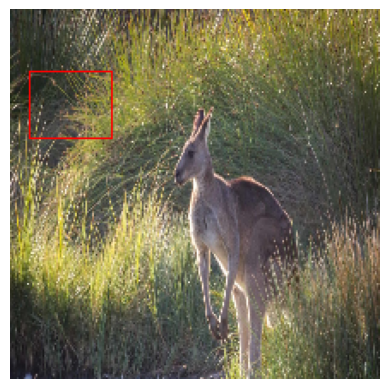

In [24]:
bounded_image = Image.open(validation_img)
bounded_image = cv2.resize(np.array(bounded_image), target_size)

bounded_image = Image.fromarray(bounded_image)

draw = ImageDraw.Draw(bounded_image)

draw.rectangle(bounding_boxes[0], outline='red', width=1)

plt.imshow(bounded_image)
plt.axis('off')
plt.show()